In [1]:
import pandas as pd
import os
from pathlib import Path
from PIL import Image
import random
import torch
from typing import Literal
import torchvision
from torchvision.datasets import ImageFolder
from tqdm.auto import tqdm
from pytorch_lightning.loggers import WandbLogger
import wandb
import torchmetrics
import shutil
import pytorch_lightning as pl
import torch.nn as nn
import matplotlib.pyplot as plt

In [2]:
RAW_DATA_DIR = Path('../raw/Garbage classification/')
DATA_DIR = Path('../data')

<BarContainer object of 6 artists>

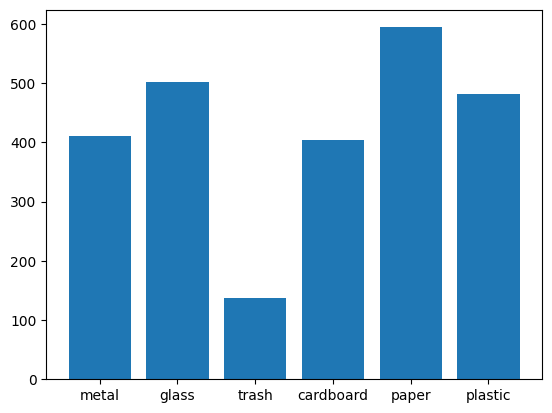

In [3]:
dct = {}
for cls in os.listdir(RAW_DATA_DIR):
    images = Path(RAW_DATA_DIR / cls).glob('*')
    # print(cls, ' has ', len(list(images)))
    dct[cls] = len(list(images))

plt.bar(dct.keys(), dct.values())

In [4]:
sum(dct.values())

2527

In [5]:
0.9 * 0.2, 0.9 * 0.8, 0.2

(0.18000000000000002, 0.7200000000000001, 0.2)

In [6]:
classes = os.listdir(RAW_DATA_DIR)
train_size = 0.72
validation_size = 0.18 # 20% of 90%
test_size = 0.10

os.makedirs(DATA_DIR, exist_ok=True)

def copy_images(image_list, src_dir, dest_dir, cls, mode:Literal['train', 'test', 'val']):
    os.makedirs(dest_dir, exist_ok=True)
    os.makedirs(dest_dir / mode, exist_ok=True)
    os.makedirs(dest_dir / mode / cls, exist_ok=True)
    for img_name in image_list:
        shutil.copy(src_dir / cls / img_name, dest_dir / mode / cls / img_name)
        

for cls in classes:
    cls_path = RAW_DATA_DIR / cls
    images = os.listdir(cls_path)
    n_train = int(len(images) * train_size)
    n_val = n_train + int(len(images) * validation_size)
    random.shuffle(images)
    train_images = images[:n_train]
    val_images = images[n_train:n_val]
    test_images = images[n_val:]
    copy_images(train_images, RAW_DATA_DIR, DATA_DIR, cls, mode='train')
    copy_images(val_images, RAW_DATA_DIR, DATA_DIR, cls, mode='val')
    copy_images(test_images, RAW_DATA_DIR, DATA_DIR, cls, mode='test')

In [7]:
transformers = torchvision.transforms.Compose([
    torchvision.transforms.Resize((128, 128)),
    torchvision.transforms.ToTensor()
])

In [8]:
train_dataset = ImageFolder(DATA_DIR / 'train', transform=transformers)
val_dataset = ImageFolder(DATA_DIR / 'val', transform=transformers)
test_dataset = ImageFolder(DATA_DIR / 'test', transform=transformers)
assert train_dataset.class_to_idx == test_dataset.class_to_idx

idx_to_class = {i:c for c, i in train_dataset.class_to_idx.items()}
idx_to_class

{0: 'cardboard', 1: 'glass', 2: 'metal', 3: 'paper', 4: 'plastic', 5: 'trash'}

In [9]:
class DataLoaderWrapper(pl.LightningDataModule):
    def __init__(self, 
                 train_dataset:torch.utils.data.Dataset,
                 test_dataset:torch.utils.data.Dataset,
                 batch_size:int=32,
                 num_workers:int=4):
        super().__init__()
        self.train_dataset = train_dataset
        self.test_dataset = test_dataset
        self.batch_size = batch_size
        self.num_workers = num_workers
 
    def train_dataloader(self):
        return torch.utils.data.DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=self.num_workers
        )
 
    def val_dataloader(self):
        return torch.utils.data.DataLoader(
            self.test_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=self.num_workers
        )

In [10]:
class SimpleCNN(nn.Module):
    def __init__(self, 
                 num_layers=5, # m
                 filter_size=3, # k
                 num_dense=128, # n
                 conv_activation=nn.ReLU,
                 dense_activation=nn.ReLU,
                 in_channels=3,
                 num_classes=6,
                 stride=1,
                 input_size=128,
                 base_features=16,
                 *args, **kwargs):
        super().__init__(*args, **kwargs)
        layers = []
        out_channels = in_channels
        w, h = input_size, input_size
        for i in range(num_layers):
            out_channels = base_features * (2 ** i)
            layers.append(
                nn.Conv2d(
                    in_channels=in_channels,
                    out_channels=out_channels,
                    kernel_size=filter_size,
                    padding='same',
                    stride=stride
                )
            )
            layers.append(conv_activation())
            layers.append(nn.MaxPool2d(kernel_size=2))
            
            w, h = w//2, h//2
            in_channels = out_channels

        self.conv = nn.Sequential(*layers)
        nn.Flatten()
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(out_channels*w*h, num_dense),
            dense_activation(),
            nn.Linear(num_dense, num_classes)
        )

    def forward(self, x):
        x = self.conv(x)
        x = self.fc(x)
        
        return x



In [11]:
# num_filters -> m 
# kernel -> k 
# dense -> n
# base_features = 16
# c_in -> 3 (input channels)

# --- CONV ---
# param in a layer -> (c_in * k * k + 1) * c_out
# c_out = c_in * (2 ** i)
# param per layer -> (3 * k * k + 1) * (base_features * (2 ** i)) # for i == 0
# param per layer -> ((base_features * (2 ** (i-1))) * k * k + 1) * (base_features * (2 ** i)) # for i > 0

# --- DENSE ---
# out_channels -> base_features * (2 ** (m-1)) # c_out of last conv layer
# w_out_convs -> w_in // (2**m)
# h_out_convs = w_out_convs
# param in dense layer[1] -> (base_features * (2 ** (m-1)) * h_out_convs * w_out_convs + 1) * n # +1 for bias
# dense layer[3] -> n * 6 + 6 # classes => 6
# dense total = (base_features * (2 ** (m-1)) + 1) * n + n * 6 + 6

# --- TOTAL ---
# total params -> (3 * k * k + 1) * (base_features * (2 ** i)) + summation(((base_features * (2 ** (i-1))) * k * k + 1) * (base_features * (2 ** i)) for i=1 to m-1) + (base_features * (2 ** (m-1)) + 1) * n + n * 6 + 6

def calculate_param(
        m:int, k:int, n:int, base_features:int, c_in:int, w_in:int, h_in:int
):
    """
    - num_filters -> m (5) 
    - kernel -> k (3)
    - dense -> n (128)
    - base_features = 16
    - c_in -> 3 (input channels)
    """
    param_conv0 = (c_in*k*k + 1) * base_features 
    mac_0 = (c_in*k*k + 1) * (w_in//2 * h_in//2 * base_features)
    print(f"param at conv0: {param_conv0}")
    print(f"MACs at conv0: {mac_0}")
    param_conv_m = 0
    mac_m = 0
    for i in range(1, m):
        param_conv_m += ((base_features * (2 ** (i-1))) * k * k + 1) * (base_features * (2 ** i))
        mac_i = ((base_features * (2 ** (i-1))) * k * k + 1) * (base_features * (2 ** i) * (w_in//(2**i)) * (h_in//(2**i)))
        mac_m += mac_i
        print(f"param at conv{i}: {((base_features * (2 ** (i-1))) * k * k + 1) * (base_features * (2 ** i))}")
        print(f"MACs at conv{i}", mac_i)

    print(f"after m convs: {param_conv_m}")
    conv_total = param_conv0 + param_conv_m

    w_out_convs = w_in // (2**m)
    h_out_convs = h_in // (2**m)
    dense_l1 = (base_features*(2**(m-1))* w_out_convs * h_out_convs + 1) * n
    print(f"param after dense1: {dense_l1}")
    dense_l3 = 6 * n + 6
    print(f"param after dense3: {dense_l3}")
    total_params = conv_total + dense_l1 + dense_l3
    print(f"total MACs: {mac_0+mac_m}")
    return total_params

calculate_param(m=5, k=3, n=128, base_features=16, c_in=3, w_in=128, h_in=128)

param at conv0: 448
MACs at conv0: 1835008
param at conv1: 4640
MACs at conv1 19005440
param at conv2: 18496
MACs at conv2 18939904
param at conv3: 73856
MACs at conv3 18907136
param at conv4: 295168
MACs at conv4 18890752
after m convs: 392160
param after dense1: 524416
param after dense3: 774
total MACs: 77578240


917798

In [12]:
import torchinfo
m = SimpleCNN()
torchinfo.summary(m, input_size=(32, 3, 128, 128)).total_params

917798

In [13]:
from typing import Any


class ModelLightning(pl.LightningModule):
    def __init__(self, 
                 model,
                 idx_to_class:dict,
                 class_weights:torch.Tensor = None,
                 lr:float=1e-3,
                 *args: Any, **kwargs: Any) -> None:
        super().__init__(*args, **kwargs)
        self.model = model

        self.idx_to_class = idx_to_class

        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=lr)
        self.criterion = nn.CrossEntropyLoss() if not class_weights else nn.CrossEntropyLoss(weight=class_weights)

        self.train_f1 = torchmetrics.F1Score('multiclass', num_classes=6,
                                       average=None)
        self.train_recall = torchmetrics.Recall('multiclass', num_classes=6, average=None)
        self.train_precision = torchmetrics.Precision('multiclass', num_classes=6, average=None)
        self.val_f1 = torchmetrics.F1Score('multiclass', num_classes=6,
                                       average=None)
        self.val_recall = torchmetrics.Recall('multiclass', num_classes=6, average=None)
        self.val_precision = torchmetrics.Precision('multiclass', num_classes=6, average=None)

    def forward(self, x) -> Any:
        return self.model(x)
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        yhat = self(x)
        loss = self.criterion(yhat, y)

        preds = torch.argmax(yhat, 1)
        self.train_f1.update(preds, y)
        self.train_recall.update(preds, y)
        self.train_precision.update(preds, y)

        self.log("train_loss", loss, on_epoch=True, prog_bar=True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        yhat = self(x)

        preds = torch.argmax(yhat, 1)
        self.val_f1.update(preds, y)
        self.val_recall.update(preds, y)
        self.val_precision.update(preds, y)
        loss = self.criterion(yhat, y)
        self.log("val_loss", loss, on_epoch=True, prog_bar=True)
        return loss
    
    def on_train_epoch_end(self) -> None:
        self._shared_logging(mode='train',
                             f1=self.train_f1, recall=self.train_recall, precision=self.train_precision,
                             )
    
    def on_validation_epoch_end(self) -> None:
        self._shared_logging(mode='val',
                             f1=self.val_f1, recall=self.val_recall, precision=self.val_precision,
                             )

    def _shared_logging(self, mode:Literal['train', 'val'], 
                        f1, recall, precision,
                        ):
        _f1 = f1.compute()
        _recall = recall.compute()
        _precision = precision.compute() 

        # per class
        for i in range(6):
            self.log(f'{mode}_f1_class_{self.idx_to_class[i]}', _f1[i], on_epoch=True)
            self.log(f'{mode}_recall_class_{self.idx_to_class[i]}', _recall[i], on_epoch=True)
            self.log(f'{mode}_precision_class_{self.idx_to_class[i]}', _precision[i], on_epoch=True)
            

        f1.reset()
        recall.reset()
        precision.reset()

    def configure_optimizers(self):
        return self.optimizer

In [ ]:
class CFG:
    batch_size = 64
    num_workers = 4
    max_epochs = 20
    lr = 1e-3
    num_layers=6 # m
    filter_size=3 # k
    num_dense=128 # n
    conv_activation=nn.ReLU
    dense_activation=nn.ReLU
    in_channels=3
    num_classes=6
    stride=1
    input_size=128
    num_classes = 6


logger = WandbLogger(
    project='garbage-classification-v1',
    name='simple-cnn-v0',
    config=CFG().__dict__
)

In [100]:
model = SimpleCNN(
    num_layers=CFG.num_layers,
    filter_size=CFG.filter_size,
    num_dense=CFG.num_dense,
    conv_activation=CFG.conv_activation,
    dense_activation=CFG.dense_activation,
    in_channels=CFG.in_channels,
    num_classes=CFG.num_classes,
    stride=CFG.stride,
    input_size=CFG.input_size
)

pl_model = ModelLightning(
    model=model,
    idx_to_class=idx_to_class,
    lr=CFG.lr
)

dm = DataLoaderWrapper(
    train_dataset=train_dataset,
    test_dataset=test_dataset,
    batch_size=CFG.batch_size,
    num_workers=CFG.num_workers
)

trainer = pl.Trainer(
    max_epochs=CFG.max_epochs,
    accelerator='auto',
    devices='auto',
    logger=logger
)

trainer.fit(pl_model, datamodule=dm)

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type                | Params | Mode 
----------------------------------------------------------------
0 | model           | SimpleCNN           | 1.8 M  | train
1 | criterion       | CrossEntropyLoss    | 0      | train
2 | train_f1        | MulticlassF1Score   | 0      | train
3 | train_recall    | MulticlassRecall    | 0      | train
4 | train_precision | MulticlassPrecision | 0      | train
5 | val_f1          | MulticlassF1Score   | 0      | train
6 | val_recall      | MulticlassRecall    | 0      | train
7 | val_precision   | MulticlassPrecision | 0      | train
----------------------------------------------------------------
1.8 M     Trainable params
0         Non-trainable params
1.8 M     Total params
7.343     Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/nevrohelios/miniconda3/envs/flsplit/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (38) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.


In [98]:
logger.experiment.finish()

epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_f1_class_cardboard,▁▅▆▆▆▇▇▇▇▇▁▃▆▆▆▇▇▇▇▇▇▇▇███████
train_f1_class_glass,▂▃▃▃▄▄▄▅▅▆▁▁▂▃▃▄▅▅▆▆▆▆▇▇▇▇▇███
train_f1_class_metal,▂▁▃▃▄▄▄▅▅▆▁▁▁▂▄▄▅▅▅▆▆▆▆▇▇▇▇▇██
train_f1_class_paper,▁▁▁▂▃▄▄▅▅▆▁▁▂▂▄▄▅▅▆▆▆▆▇▇▇▇████
train_f1_class_plastic,▁▄▄▅▅▅▅▆▆▆▃▃▄▄▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
train_f1_class_trash,▁▁▁▃▄▅▅▅▅▅▁▁▁▃▄▄▅▅▅▅▆▆▆▆▆▇▇▇██
train_loss,█▇▆▅▅▄▃▂▂▁
train_loss_epoch,██▇▇▆▅▅▅▄▄▃▃▃▃▂▂▂▂▁▁
train_loss_step,█▇▇▇▄▅▃▂▃▁▁▁▂▁▂
+32,...
